#Beer Analysis

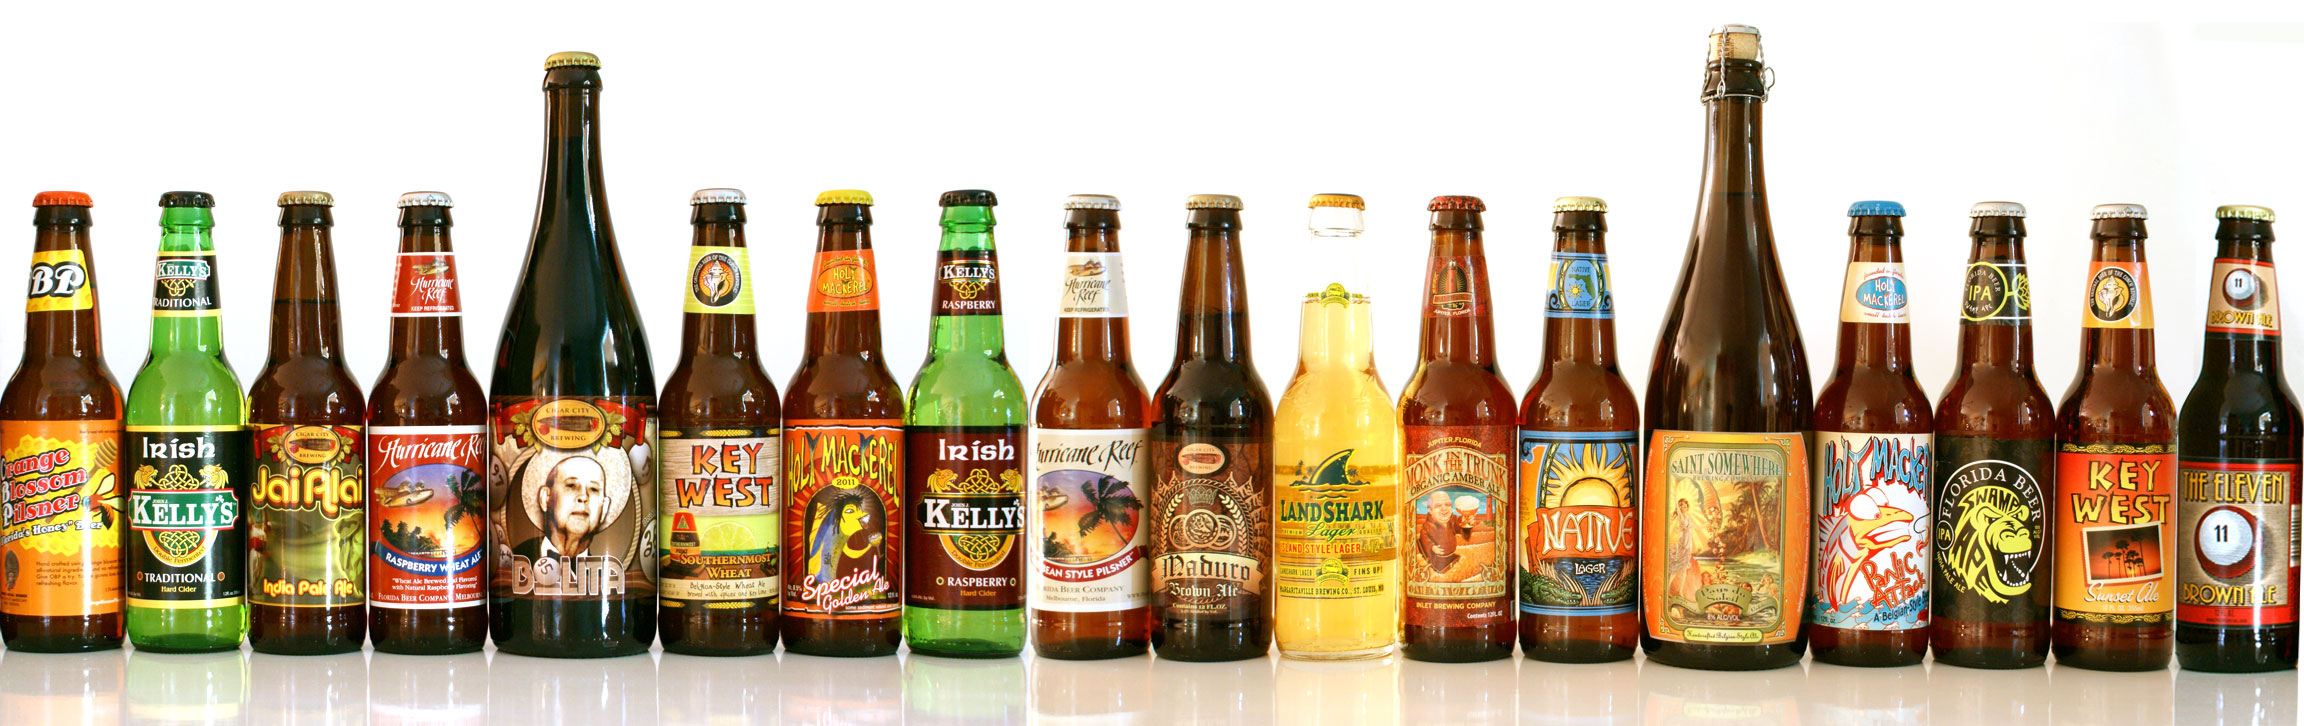

In [1]:
from IPython.display import Image
Image('http://cache.trustedpartner.com/images/library/PalmBeachIllustrated2010/News%20&%20Blogs/Dining/1%20FL%20Beer/beer-lineup-big-all.jpg',
      width=800)

#Objective:
Improve my beer knowledge and and data science skills at the same time. Apply machine learning techniques to analize the data sets.

#Data Source
[RateBeer.com](http://www.ratebeer.com/) - the most popular beer review websites, founded in May 2000.

#Project Milestones
###Step 1: Web Scraping (*Not in this notebook)
Developped a web scraper to fetch these below four kinds of data sets from the wbsite and temporary store them in a MongoDB at home. It was useful because I was not sure what kinds of fields I wwould get such as extra fields just for sesonal beers.
    - Brewer info
    - Beer info
    - Review
    - User info

###Step 2: Data Clean Up and Normalization (*Not in this notebook)
The data in mongodb was not clean enough to work on. So spend significant amount of effort for data munging and normalized the data. Then moved the clean data out from MongoDB at home to a PostgreSQL on AWS. Created appropriate indexes and view tables. Also created a de-normalized table with some selected data for efficiency. 

###Step 3: Exploratory Analysis (*This notebook starts from here)
Visualize some key stats to understand the data and rating calculation for RateBeer.com.

###Step 4:  Beer Type Classification, Lager or Ale?
All the beers are either Lager or Ale. Feed reviews and some other info to Random Forest to classify.

###Step 5:  Beer Group Classification
Using the same approach as step4, classify into more granular level six beer groups.

###Step 6:  Review Topic Delection
There four rating fields. Using review and other data, idenfity if a review is about which one of thoese topics. 

###Step 7: Extract Topic Key Words
Extract dominant words from user reviews depending on the topics and then identify the importance relative to other topics. 

###Step 8: Create Word Clouds for Topic Key Words
Based on the results of step7, create Word Clouds to visualize

In [1]:
import numpy as np
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from __future__ import division

In [2]:
%matplotlib inline
sns.set_style('whitegrid')

#Connect to PostgreSQL on AWS

In [4]:
from sqlalchemy import create_engine

engine = create_engine('postgresql://user:pass.rds.amazonaws.com:5432/beer')

#Step 3: Exploratory Analysis
Let's get some quick stats to understand our data!

In [89]:
query = '''
SELECT COUNT(*)
FROM beer;
'''
beer = pd.read_sql(query, engine)

In [90]:
query = '''
SELECT COUNT(*)
FROM review;
'''
review = pd.read_sql(query, engine)

In [91]:
query = '''
SELECT COUNT(*)
FROM brewer;
'''
brewer = pd.read_sql(query, engine)

In [95]:
query = '''
SELECT COUNT(*)
FROM person;
'''
user = pd.read_sql(query, engine)

In [103]:
stats = pd.concat([beer, review, brewer, user], axis=1)
stats.columns = ['beer', 'review', 'brewer', 'user']
stats.index = ['Total']
print 'Number of records in a database'
stats

Number of records in a database


,beer,review,brewer,user
Total,291913,6898186,18680,60481


In [102]:
query = '''
SELECT avg(beercount)
FROM (SELECT COUNT(beer_id) AS beercount FROM beerview GROUP BY brewer_name) dummy;
'''
print 'Average number of beers per brewer'
pd.read_sql(query, engine)

Average number of beers per brewer


,avg
0,15.635404


Here is the very higher view of our data stats. There are **18,680 brewers** and they are maing **291,913 beers**, which means on average each brewer is manufacturing **15 beers**. Also RateBeer has **6,898,186 user reviews** as of 3/5/2015. That is a quite lot of reviews, especially based on the number of users they have. If we simply divide 6,898,186 reviews by 60,481 users, we get **114.055 reviews/user**! Now let's take a look at brewer data.

## Brewer by Country

In [179]:
query = '''
SELECT
    country_name,
    COUNT(*)
FROM brewerview
GROUP BY country_name
ORDER BY COUNT(*) DESC;
'''
brewer = pd.read_sql(query, engine)

In [185]:
top10 = brewer[:10]
top10.loc[10] = ['Other', brewer[10:]['count'].sum()]
top10

/home/ikkei/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


,country_name,count
0,United States,5145
1,England,1952
2,Germany,1816
3,France,775
4,Italy,748
5,Canada,726
6,Japan,667
7,Spain,595
8,Australia,441
9,Switzerland,391


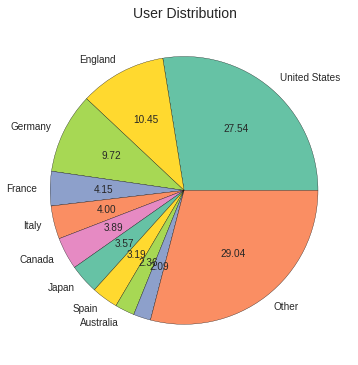

In [196]:
x = top10['count']
x_labels = top10.country_name.tolist()[:9] + [''] * 1 + top10.country_name.tolist()[-1:]

plt.figure(figsize=(6, 6), dpi=80)
plt.pie(x, labels=x_labels, colors=colors, autopct='%.2f')

plt.title('Brewer Distribution', fontsize=14)
plt.show()

As RateBeer is a U.S.-based English website, it makes sense that it has a lot of brewer's info that is located in the U.S.

## User by Country

In [104]:
query = '''
SELECT 
    country_name,
    COUNT(*)
FROM personview
WHERE country_name IS NOT NULL
GROUP BY country_name
ORDER BY COUNT(*) DESC;
'''
user = pd.read_sql(query, engine)

In [140]:
top10 = user[:10]
others = user['count'][10:].sum()
top10.loc[10] = ['Others', others]

/home/ikkei/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [178]:
print 'User distribution'
top10

User distribution


,country_name,count
0,United States,25798
1,Canada,2793
2,England,1957
3,Australia,1175
4,Netherlands,851
5,Denmark,846
6,Belgium,817
7,Sweden,816
8,Italy,689
9,Poland,632


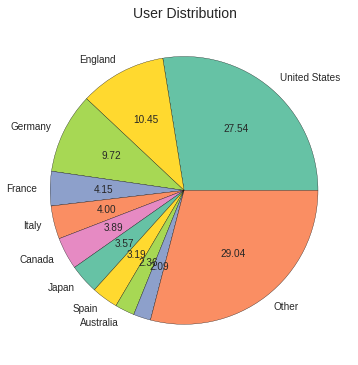

In [198]:
x = top10['count']
x_labels = top10.country_name.tolist()[:9] + [''] * 1 + top10.country_name.tolist()[-1:]

from random import shuffle
colors = sns.color_palette("Set2")
shuffle(colors)

plt.figure(figsize=(6, 6), dpi=80)
plt.pie(x, labels=x_labels, colors=colors, autopct='%.2f')

plt.title('User Distribution', fontsize=14)
plt.show()

This pie chart is very similar to brewer's pie chart we saw earlier. This is indicating that **American users like to write their reviews for American beers** and British for British beers. It is interesting that RateBeer only has 9.72% of German users knowing high beer consumption here. Maybe they have their own German beer review sites.

## Rating Analysis

<img src="image/ratebeer_screen_shot.png">

### User Ratings

In [200]:
query = '''
SELECT
    AVG(overall) AS overall,
    AVG(taste) AS taste,
    AVG(aroma) AS aroma,
    AVG(palate) AS palate,
    AVG(appearance) AS appearance
FROM review;
'''
print 'Average rating'
pd.read_sql(query, engine)

Average rating


,overall,taste,aroma,palate,appearance
0,13.237036,6.502374,6.419135,3.284923,3.441499


RateBeer sets differnt scoring scales for each of these above rating fields. This is their way to put **more weight on taste rather than appearance**. **Final score = (overall+ taste	+ aroma + palate + appearance) / 10**. 

### Beer Ratings

In [211]:
query = '''
SELECT
    weighted_avg,
    num_ratings
FROM beerview
where weighted_avg > 0 AND
num_ratings > 0;
'''
review = pd.read_sql(query, engine)

In [212]:
review.describe()

,weighted_avg,num_ratings
count,259073.000000,259073.000000
mean,2.952683,23.978141
std,0.303105,107.256872
min,1.010000,1.000000
25%,2.810000,2.000000
50%,2.920000,4.000000
75%,3.110000,13.000000
max,4.480000,4764.000000


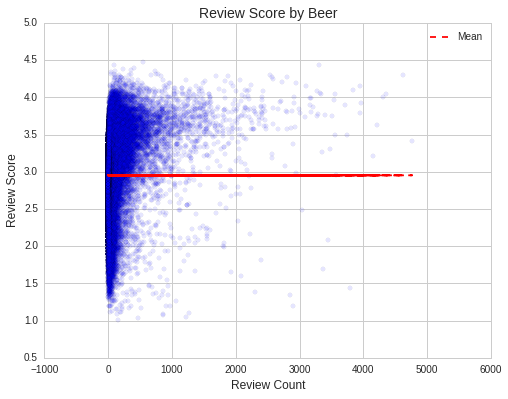

In [222]:
x = review.num_ratings
y = review.weighted_avg

y_mean = y.mean()
y_means = [y_mean for i in x]


plt.figure(figsize=(8, 6), dpi=80)
plt.scatter(x, y, alpha=0.1)
plt.plot(x, y_means, label='Mean', linestyle='--', c='r')

plt.title('Review Score by Beer', fontsize=14)
plt.ylabel('Review Score', fontsize=12)
plt.xlabel('Review Count', fontsize=12)

plt.legend(loc='upper right')
plt.show()

Each dot represents one beer. The distribution is **skewed** to 5 and overall man is 3.9. This is a human behavior, we like to comment more on what we like.

## Ratings by Style
Let's see what the best beer style is!

In [216]:
query = '''
with s as 
(
    select
    style_name,
    count(*),
    avg(bold_score) ,
    stddev(weighted_avg)
    from reviewmaster2
    group by style_name
)

SELECT
    s.style_name,
    g.group_name,
    s.count,
    s.avg,
    s.stddev
FROM s
LEFT join beerstyleview g
    on s.style_name = g.style_name
ORDER BY s.avg desc
'''
styles = pd.read_sql(query, engine)

###To 10 styles by average rating

In [217]:
styles[:10]

,style_name,group_name,count,avg,stddev
0,Imperial Stout,Stouts and Porters,194918,3.889933,0.290535
1,Lambic Style Gueuze,Sour Beer,12720,3.836785,0.305584
2,Abt Quadrupel,Belgian-Style Ales,32372,3.825828,0.320631
3,Imperial Strong Porter,Stouts and Porters,28789,3.788433,0.247575
4,Sour Red Brown,Sour Beer,31908,3.768099,0.284056
5,Imperial Double Ipa,Anglo-American Ales,163251,3.762736,0.277671
6,Sour Wild Ale,Sour Beer,74301,3.744488,0.307459
7,Lambic Style Unblended,Sour Beer,2846,3.728496,0.204839
8,Barley Wine,Anglo-American Ales,104818,3.712430,0.276587
9,Baltic Porter,Stouts and Porters,17180,3.688527,0.285164


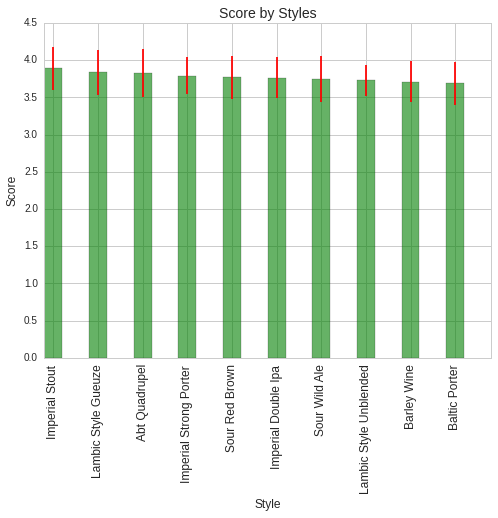

In [219]:
n = 10
width = 0.4

x = np.arange(n)
y = styles.avg[:n]
std = styles.stddev[:n]
x_labels = styles.style_name[:n].tolist()

plt.figure(figsize=(8, 6), dpi=80)
plt.bar(x, y, width=width, color='g', yerr=std, ecolor='r', alpha=0.6)

plt.xticks(x + width / 2, x_labels, rotation=90, fontsize=12)
plt.title('Score by Style', fontsize=14)
plt.ylabel('Score', fontsize=12)
plt.xlabel('Style', fontsize=12)

plt.legend(loc='upper right')
plt.show()

Imperial Stout is got the highest rating. Lots of **strong ale** beers but there is **no lager!**

### Top 10 styles by review count

In [66]:
styles.sort('count', ascending=False, inplace=True)
styles[:10]

,style_name,group_name,count,avg,stddev
23,India Pale Ale Ipa,Anglo-American Ales,276943,3.525721,0.292899
0,Imperial Stout,Stouts and Porters,194918,3.889933,0.290535
5,Imperial Double Ipa,Anglo-American Ales,163251,3.762736,0.277671
34,American Pale Ale,Anglo-American Ales,133517,3.335877,0.298376
11,Belgian Strong Ale,Belgian-Style Ales,132750,3.652319,0.257900
8,Barley Wine,Anglo-American Ales,104818,3.712430,0.276587
26,Porter,Stouts and Porters,104491,3.474063,0.292019
10,American Strong Ale,Anglo-American Ales,88439,3.661904,0.281831
18,Saison,Belgian-Style Ales,86485,3.572314,0.270687
42,Amber Ale,Anglo-American Ales,81806,3.175861,0.312283


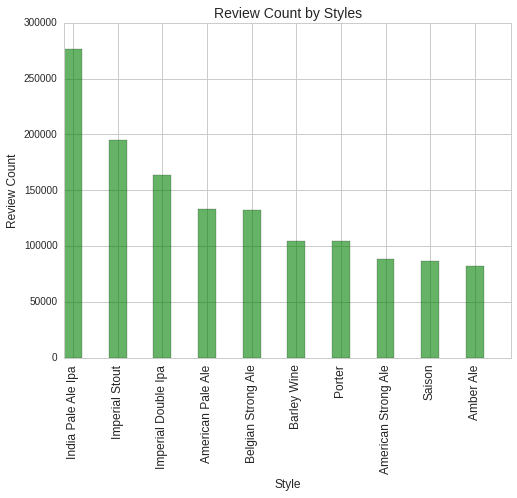

In [78]:
n = 10
width = 0.4

x = np.arange(n)
y = styles['count'][:n]
x_labels = styles.style_name[:n].tolist()

plt.figure(figsize=(8, 6), dpi=80)
plt.bar(x, y, width=width, color='g', alpha=0.6)

plt.xticks(x + width / 2, x_labels, rotation=90, fontsize=12)
plt.title('Review Count by Style', fontsize=14)
plt.ylabel('Review Count', fontsize=12)
plt.xlabel('Style', fontsize=12)

plt.legend(loc='upper right')
plt.show()

IPA got **far more reviews than other other styles**. IPA was not even on the top 10 bar chart above. Again lots of strong beers here.

#Step 4: Beer Type Classification, Lager or Ale?
All the beers are either ale or lager.

In [237]:
Image(url='http://infographics-images.idlelist.com/wp-content/uploads/2013/02/the-wide-world-of-beer-743x1024.jpg',
     width=500)

In order to simplify the probem, I will start from binary classification, lager or ale? That is the second level of this beer tree below.

<img src="image/beer_type_tree.png">

In [226]:
query = '''
SELECT 
    style_name,
    group_name,
    CASE group_name
        WHEN 'Lager' THEN 'Lager' 
        ELSE 'Ale'
    END AS type
FROM beerstyleview
WHERE group_name != 'Non-Beer' AND
group_name IS NOT NULL
ORDER BY type, group_name, style_name
'''

pd.read_sql(query, engine)

,style_name,group_name,type
0,Altbier,Anglo-American Ales,Ale
1,Amber Ale,Anglo-American Ales,Ale
2,American Pale Ale,Anglo-American Ales,Ale
3,American Strong Ale,Anglo-American Ales,Ale
4,Barley Wine,Anglo-American Ales,Ale
5,Bitter,Anglo-American Ales,Ale
6,Brown Ale,Anglo-American Ales,Ale
7,Cream Ale,Anglo-American Ales,Ale
8,English Pale Ale,Anglo-American Ales,Ale
9,English Strong Ale,Anglo-American Ales,Ale


Select review data which was written by users who live in the U.S. Only choose included reviews (RateBeer does not include your reviews toward rating calculation unless you reviews more than 10 beers.) Also there are some reviews for non-beer such as Sake, exclude those. The data set is already randomized in the database. For computation efficiency, only select 2,500 reviews for lager and non-lager.

In [292]:
def fetch_data(cutoff_logic):
    query = '''
SELECT 
    beer_name, 
    brewer_name, 
    brewer_country_name, 
    brewer_type,
    style_name,
    group_name,
    glass_type, 
    num_ratings, 
    weighted_avg, 
    alcohol_by_volume,  
    est_calories, 
    seasonal, 
    user_name,
    us_state,
    favorite_style,
    joined_date,
    bold_score, 
    overall_score, 
    taste_score, 
    palate_score, 
    aroma_score, 
    appearance_score, 
    review
FROM reviewmaster2
WHERE
    alcohol_by_volume IS NOT NULL AND
    est_calories IS NOT NULL AND
    us_state IS NOT NULL AND 
    favorite_style IS NOT NULL AND
    group_name %s 
LIMIT 2500;
    ''' % cutoff_logic
    
    return pd.read_sql(query, engine)

lager = fetch_data("= 'Lager'")
nonlager = fetch_data("!= 'Lager'")

lager['is_lager'] = True
nonlager['is_lager'] = False
beer = lager.append(nonlager)
beer['is_seasonal'] = beer.seasonal.notnull()
beer['group_id'] = pd.Categorical(beer.group_name).codes

Make sure there is not null values.

In [293]:
beer.count()

beer_name              5000
brewer_name            5000
brewer_country_name    5000
brewer_type            5000
style_name             5000
group_name             5000
glass_type             5000
num_ratings            5000
weighted_avg           5000
alcohol_by_volume      5000
est_calories           5000
seasonal               1652
user_name              5000
us_state               5000
favorite_style         5000
joined_date            5000
bold_score             5000
overall_score          5000
taste_score            5000
palate_score           5000
aroma_score            5000
appearance_score       5000
review                 5000
is_lager               5000
is_seasonal            5000
group_id               5000
dtype: int64

In [294]:
beer.head(3)

,beer_name,brewer_name,brewer_country_name,brewer_type,style_name,group_name,glass_type,num_ratings,weighted_avg,alcohol_by_volume,...,bold_score,overall_score,taste_score,palate_score,aroma_score,appearance_score,review,is_lager,is_seasonal,group_id
0,Fosters Lager,Fosters Brewing (CUB),Australia,Commercial Brewery,Pale Lager,Lager,Dimpled mug,1804,2.00,4.9,...,1.7,7,3,2,3,2,"I'm sure this joke's been done 100 times, but:...",True,False,2
1,Rockman High Gravity Lager,Sleeman Brewing & Malting Co. (Sapporo),Canada,Commercial Brewery,Malt Liquor,Lager,Lager glass,22,1.37,8.0,...,0.6,1,1,1,2,1,There are too many things wrong with this beer...,True,False,2
2,Moosbacher Kellerbier,Private Landbrauerei Scheuerer,Germany,Commercial Brewery,Zwickel Keller Landbier,Lager,Dimpled mug,220,2.98,5.2,...,3.2,13,7,4,4,4,Delicious and smooth. Pours a nice medium brow...,True,False,2


Create dummies for the categorical columns.

In [295]:
def concat_dummies(cols):
    dfs = []
    for col in cols:
        prefix = col.replace('_', '')
        dfs.append(pd.get_dummies(beer[col], prefix=prefix).iloc[:, 1:])
    return pd.concat(dfs, axis=1)

dummy_cols = ['brewer_country_name', 'brewer_type', 'glass_type']
beer_d = concat_dummies(dummy_cols)

Add other numerical fields to beer_dummy DF.

In [296]:
num_cols = ['num_ratings', 'weighted_avg', 'alcohol_by_volume', 'est_calories']
for col in num_cols:
    beer_d[col] = beer[col]

beer_d['is_seasonal'] = beer.seasonal.notnull()

In [297]:
beer_d.head(3)

,brewercountryname_Argentina,brewercountryname_Armenia,brewercountryname_Aruba,brewercountryname_Australia,brewercountryname_Austria,brewercountryname_Bahamas,brewercountryname_Barbados,brewercountryname_Belgium,brewercountryname_Bhutan,brewercountryname_Bolivia,...,glasstype_Thistle,glasstype_Trappist glass,glasstype_Tulip,glasstype_Tumbler,glasstype_Weizen,num_ratings,weighted_avg,alcohol_by_volume,est_calories,is_seasonal
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1804,2.00,4.9,147,False
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,22,1.37,8.0,240,False
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,220,2.98,5.2,156,False


### Text clean up
Using NLTK clean up review text. 
1. Tokenize a sentence.
2. remove stop words and extra un-wanted words.
3. Make sure there are only alphabets. Dash betwwen words are ok.
4. A word have to be at least two characters.
5. Stem words.

In [346]:
import re
import nltk
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

unwanted_words = ['beer', 'updated', 'lager', 'ipa', 'ale']

def tokenize_and_stem(text):
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]

    # select only alphabets from tokens
    filtered_tokens = []
    for token in tokens:    
        if re.match('^[a-z][a-z-\']+[a-z]$', token):
            if len(token) >= 2 and token not in unwanted_words:
                filtered_tokens.append(token)
            
    return [stemmer.stem(t) for t in filtered_tokens]

### Vectorlize
Using Tf-idf Vectorizer, vectorize review text. 
- max_df=0.9 : ignore the words that appear more than 90%.
- min_df=0.01: ignore the words that do not appear more than 1%.

In [347]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(max_df=0.9,
                             min_df=0.01, 
                             stop_words='english',
                             strip_accents='ascii',
                             use_idf=True, 
                             tokenizer=tokenize_and_stem, 
                             ngram_range=(1,2))

tfidf_matrix = tfidf_vect.fit_transform(beer.review)
x_back = tfidf_matrix.toarray()
x_back_cols = tfidf_vect.get_feature_names()

tfidf_df = pd.DataFrame(x_back, columns=x_back_cols)
tfidf_df.head()

,abv,acid,actual,aftertast,age,alcohol,amaz,amber,amber color,american,...,wood,woodi,work,worth,wow,year,yeast,yeasti,yellow,yellow color
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Train Random Forest model 
Use GridSearchCV to tune hyperparameters.

In [348]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV

In [349]:
target_col = 'is_lager'

beer_d.reset_index(inplace=True, drop=True)
tfidf_df.reset_index(inplace=True, drop=True)

X = beer_d.join(tfidf_df)
y = beer[target_col]

rfc = RandomForestClassifier(random_state=1)
tuned_parameters = [{'max_features': ['sqrt', 'log2'], 
                     'n_estimators': [20, 100, 200, 500, 1000]}]

clf = GridSearchCV(rfc, tuned_parameters, scoring='roc_auc', cv=3, n_jobs=-1, verbose=2)
# clf = GridSearchCV(rfc, tuned_parameters, scoring='accuracy', cv=3, n_jobs=1, verbose=2)
clf.fit(X.values, y.values)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done   1 jobs       | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.3min finished


[CV] max_features=sqrt, n_estimators=20 ..............................
[CV] max_features=sqrt, n_estimators=20 ..............................
[CV] max_features=sqrt, n_estimators=20 ..............................
[CV] max_features=sqrt, n_estimators=100 .............................
[CV] ..................... max_features=sqrt, n_estimators=20 -   0.8s[CV] ..................... max_features=sqrt, n_estimators=20 -   0.8s[CV] ..................... max_features=sqrt, n_estimators=20 -   0.8s[CV] .................... max_features=sqrt, n_estimators=100 -   3.1s



[CV] max_features=sqrt, n_estimators=100 .............................[CV] max_features=sqrt, n_estimators=100 .............................[CV] max_features=sqrt, n_estimators=200 .............................[CV] max_features=sqrt, n_estimators=200 .............................



[CV] .................... max_features=sqrt, n_estimators=100 -   2.8s[CV] .................... max_features=sqrt, n_estimators=100 -   3.5s[CV] ...

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False),
       fit_params={}, iid=True, loss_func=None, n_jobs=-1,
       param_grid=[{'max_features': ['sqrt', 'log2'], 'n_estimators': [20, 100, 200, 500, 1000]}],
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring='roc_auc', verbose=2)

In [350]:
clf.grid_scores_

[mean: 0.98669, std: 0.00100, params: {'max_features': 'sqrt', 'n_estimators': 20},
 mean: 0.99111, std: 0.00092, params: {'max_features': 'sqrt', 'n_estimators': 100},
 mean: 0.99167, std: 0.00133, params: {'max_features': 'sqrt', 'n_estimators': 200},
 mean: 0.99201, std: 0.00135, params: {'max_features': 'sqrt', 'n_estimators': 500},
 mean: 0.99231, std: 0.00134, params: {'max_features': 'sqrt', 'n_estimators': 1000},
 mean: 0.97604, std: 0.00394, params: {'max_features': 'log2', 'n_estimators': 20},
 mean: 0.98836, std: 0.00278, params: {'max_features': 'log2', 'n_estimators': 100},
 mean: 0.98940, std: 0.00335, params: {'max_features': 'log2', 'n_estimators': 200},
 mean: 0.98998, std: 0.00285, params: {'max_features': 'log2', 'n_estimators': 500},
 mean: 0.98996, std: 0.00267, params: {'max_features': 'log2', 'n_estimators': 1000}]

In [351]:
clf.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

[[611  33]
 [  6 600]]

Accuracy 0.9688
Precision 0.947867298578



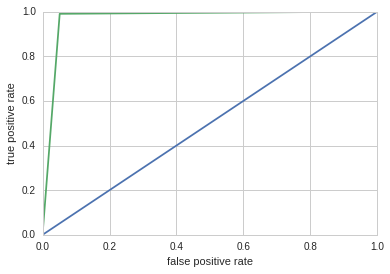

In [352]:
from sklearn.cross_validation import train_test_split
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.25)

rfc = clf.best_estimator_
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

cm = metrics.confusion_matrix(y_test, y_pred)
print cm
print

print 'Accuracy', metrics.accuracy_score(y_test, y_pred)
print 'Precision', metrics.precision_score(y_test, y_pred)
print 

roc = metrics.roc_curve(y_test, y_pred)
plt.figure()

# dummy, what's the worst random job we can do?
plt.plot([0, 0.5, 1], [0, 0.5, 1])

plt.plot(roc[0], roc[1])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')

In [353]:
feat_imp = pd.DataFrame({'feature':X.columns, 
                         'importance':rfc.feature_importances_,
                         'std': np.std([t.feature_importances_ for t in rfc.estimators_], axis=0)
                        })
feat_imp.sort('importance', ascending=False, inplace=True)

In [354]:
feat_imp[:10]

,feature,importance,std
98,glasstype_Dimpled mug,0.174229,0.144297
114,weighted_avg,0.068386,0.068113
99,glasstype_English pint,0.059756,0.047469
116,est_calories,0.037979,0.047753
104,glasstype_Shaker,0.037448,0.039511
115,alcohol_by_volume,0.035747,0.045469
105,glasstype_Snifter,0.023982,0.032504
95,brewertype_Commercial Brewery,0.018891,0.030062
100,glasstype_Flute,0.018348,0.022363
109,glasstype_Trappist glass,0.017172,0.021732


Accuracy came out 99%! This is very high. Looking at the top 10 feature importance, it seems like certain beers are served in particular glasses. **Dimpled mug is used mainly for lager**. Whereas **English pint is for ale.**

## Beer Group Classification
Now using the same approach, going to classify six beer groups, which is the third level of the beer style tree. If beer glass is a good indication of beer types ale or lager, probably this approach will work for beer group classification too.

###Hyperparameter Tuning

In [355]:
target_col = 'group_id'

beer_d.reset_index(inplace=True, drop=True)
tfidf_df.reset_index(inplace=True, drop=True)

X = beer_d.join(tfidf_df)
y = beer[target_col]

rfc = RandomForestClassifier(random_state=1)
tuned_parameters = [{'max_features': ['sqrt', 'log2'], 
                     'n_estimators': [20, 100, 200, 500, 1000]}]

clf = GridSearchCV(rfc, tuned_parameters, scoring='accuracy', cv=3, n_jobs=-1, verbose=2)
clf.fit(X.values, y.values)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done   1 jobs       | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.4min finished


[CV] max_features=sqrt, n_estimators=20 ..............................
[CV] max_features=sqrt, n_estimators=20 ..............................
[CV] max_features=sqrt, n_estimators=20 ..............................
[CV] max_features=sqrt, n_estimators=100 .............................
[CV] ..................... max_features=sqrt, n_estimators=20 -   0.9s[CV] ..................... max_features=sqrt, n_estimators=20 -   1.0s[CV] ..................... max_features=sqrt, n_estimators=20 -   0.9s[CV] .................... max_features=sqrt, n_estimators=100 -   3.3s



[CV] max_features=sqrt, n_estimators=100 .............................[CV] max_features=sqrt, n_estimators=100 .............................[CV] max_features=sqrt, n_estimators=200 .............................[CV] max_features=sqrt, n_estimators=200 .............................



[CV] .................... max_features=sqrt, n_estimators=100 -   3.7s[CV] .................... max_features=sqrt, n_estimators=100 -   3.3s[CV] ...

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False),
       fit_params={}, iid=True, loss_func=None, n_jobs=-1,
       param_grid=[{'max_features': ['sqrt', 'log2'], 'n_estimators': [20, 100, 200, 500, 1000]}],
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring='accuracy', verbose=2)

In [356]:
clf.grid_scores_

[mean: 0.90260, std: 0.00709, params: {'max_features': 'sqrt', 'n_estimators': 20},
 mean: 0.91880, std: 0.00448, params: {'max_features': 'sqrt', 'n_estimators': 100},
 mean: 0.92020, std: 0.00643, params: {'max_features': 'sqrt', 'n_estimators': 200},
 mean: 0.92200, std: 0.00492, params: {'max_features': 'sqrt', 'n_estimators': 500},
 mean: 0.92140, std: 0.00470, params: {'max_features': 'sqrt', 'n_estimators': 1000},
 mean: 0.84820, std: 0.00139, params: {'max_features': 'log2', 'n_estimators': 20},
 mean: 0.88320, std: 0.00638, params: {'max_features': 'log2', 'n_estimators': 100},
 mean: 0.88680, std: 0.00473, params: {'max_features': 'log2', 'n_estimators': 200},
 mean: 0.89240, std: 0.00481, params: {'max_features': 'log2', 'n_estimators': 500},
 mean: 0.89080, std: 0.00750, params: {'max_features': 'log2', 'n_estimators': 1000}]

In [357]:
clf.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [358]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.25)

rfc = clf.best_estimator_
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

cm = metrics.confusion_matrix(y_test, y_pred)
print cm
print

print 'Accuracy', metrics.accuracy_score(y_test, y_pred)
print 'Precision', metrics.precision_score(y_test, y_pred)
print 


[[247   0  45   0   6   1]
 [  2  89   0   0   0   0]
 [  5   0 626   0   0   0]
 [  4   0   3  31   2   1]
 [ 12   0   0   1 129   0]
 [  2   1   3   0   0  40]]

Accuracy 0.9296
Precision 0.929767089827



/home/ikkei/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)


92% of accuracy and precision! That is very good! Let's look at feature importance.

In [359]:
feat_imp = pd.DataFrame({'feature':X.columns, 
                         'importance':rfc.feature_importances_,
                         'std': np.std([t.feature_importances_ for t in rfc.estimators_], axis=0)
                        })
feat_imp.sort('importance', ascending=False, inplace=True)
feat_imp[:10]

,feature,importance,std
98,glasstype_Dimpled mug,0.093586,0.065806
109,glasstype_Trappist glass,0.046811,0.032641
99,glasstype_English pint,0.046717,0.029732
114,weighted_avg,0.040725,0.032051
104,glasstype_Shaker,0.034167,0.026672
115,alcohol_by_volume,0.030778,0.025914
116,est_calories,0.029018,0.023927
105,glasstype_Snifter,0.023791,0.020735
172,black,0.015650,0.014959
213,chocol,0.013701,0.013246


Again glass types came out at the top of the list. Since there is a clear relationship between glass types and beer styles, let's train a model purely based on reviews!

## Train Random Forest With Just Reviews

In [360]:
target_col = 'is_lager'

beer_d.reset_index(inplace=True, drop=True)
tfidf_df.reset_index(inplace=True, drop=True)

X = tfidf_df
y = beer[target_col]

rfc = RandomForestClassifier(random_state=1)
tuned_parameters = [{'max_features': ['sqrt', 'log2'], 
                     'n_estimators': [20, 100, 200, 500, 1000]}]

clf = GridSearchCV(rfc, tuned_parameters, scoring='accuracy', cv=3, n_jobs=-1, verbose=2)
clf.fit(X.values, y.values)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done   1 jobs       | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.4min finished


[CV] max_features=sqrt, n_estimators=20 ..............................
[CV] max_features=sqrt, n_estimators=20 ..............................
[CV] max_features=sqrt, n_estimators=20 ..............................
[CV] max_features=sqrt, n_estimators=100 .............................
[CV] ..................... max_features=sqrt, n_estimators=20 -   0.9s[CV] ..................... max_features=sqrt, n_estimators=20 -   1.0s[CV] ..................... max_features=sqrt, n_estimators=20 -   1.1s[CV] .................... max_features=sqrt, n_estimators=100 -   3.9s



[CV] max_features=sqrt, n_estimators=100 .............................[CV] max_features=sqrt, n_estimators=100 .............................[CV] max_features=sqrt, n_estimators=200 .............................[CV] max_features=sqrt, n_estimators=200 .............................



[CV] .................... max_features=sqrt, n_estimators=100 -   3.9s[CV] .................... max_features=sqrt, n_estimators=100 -   4.1s[CV] ...

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False),
       fit_params={}, iid=True, loss_func=None, n_jobs=-1,
       param_grid=[{'max_features': ['sqrt', 'log2'], 'n_estimators': [20, 100, 200, 500, 1000]}],
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring='accuracy', verbose=2)

In [361]:
clf.grid_scores_

[mean: 0.74280, std: 0.01037, params: {'max_features': 'sqrt', 'n_estimators': 20},
 mean: 0.76160, std: 0.01239, params: {'max_features': 'sqrt', 'n_estimators': 100},
 mean: 0.76560, std: 0.01057, params: {'max_features': 'sqrt', 'n_estimators': 200},
 mean: 0.76460, std: 0.01255, params: {'max_features': 'sqrt', 'n_estimators': 500},
 mean: 0.76540, std: 0.00985, params: {'max_features': 'sqrt', 'n_estimators': 1000},
 mean: 0.73840, std: 0.00347, params: {'max_features': 'log2', 'n_estimators': 20},
 mean: 0.76180, std: 0.00474, params: {'max_features': 'log2', 'n_estimators': 100},
 mean: 0.77120, std: 0.00897, params: {'max_features': 'log2', 'n_estimators': 200},
 mean: 0.76880, std: 0.01079, params: {'max_features': 'log2', 'n_estimators': 500},
 mean: 0.77040, std: 0.00907, params: {'max_features': 'log2', 'n_estimators': 1000}]

In [362]:
clf.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

[[491 131]
 [155 473]]

Accuracy 0.7712
Precision 0.783112582781



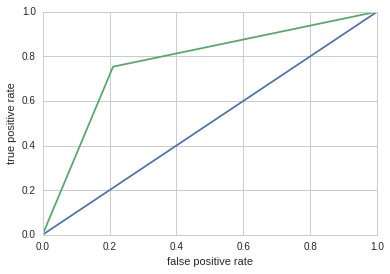

In [363]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.25)

rfc = clf.best_estimator_
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

cm = metrics.confusion_matrix(y_test, y_pred)
print cm
print

print 'Accuracy', metrics.accuracy_score(y_test, y_pred)
print 'Precision', metrics.precision_score(y_test, y_pred)
print 

roc = metrics.roc_curve(y_test, y_pred)
plt.figure()

# dummy, what's the worst random job we can do?
plt.plot([0, 0.5, 1], [0, 0.5, 1])

plt.plot(roc[0], roc[1])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')

77% accuracy and 78% precision. Not bad. Let's look at feature importance.

In [364]:
feat_imp = pd.DataFrame({'feature':X.columns, 
                         'importance':rfc.feature_importances_,
                         'std': np.std([t.feature_importances_ for t in rfc.estimators_], axis=0)
                        })
feat_imp.sort('importance', ascending=False, inplace=True)
feat_imp[:10]

,feature,importance,std
96,citrus,0.014004,0.011123
382,pour,0.011374,0.006013
226,head,0.010743,0.004193
356,orang,0.010736,0.009293
16,aroma,0.009715,0.004121
279,light,0.009593,0.004824
303,malt,0.009542,0.004099
489,tast,0.009404,0.004673
475,sweet,0.008703,0.003933
181,flavor,0.008309,0.003604


Looks good. Citrus is a good indication of ale beer (especially Anglo-American Ales) for example.

In [365]:
from sklearn.tree import export_graphviz

X_labels = [l.encode('ascii', 'ignore') for l in X.columns]

with open('./images/lager_nonlager_rfc.dot', 'wb') as f:
    f = export_graphviz(rfc.estimators_[0], out_file=f, feature_names=X_labels)

<img src="image/lager_nonlager_rfc_zoom.png">

#Step 6: Review Topic Delection
This time I am going to select all of the valid data from PostgreSQL. Again will use Random Forest model. As data is big, it will get complicated and take a lot of computation time.

In [5]:
query = '''
SELECT 
    beer_name, 
    brewer_name, 
    brewer_country_name, 
    brewer_type,
    style_name,
    group_name,
    glass_type, 
    num_ratings, 
    weighted_avg, 
    alcohol_by_volume,  
    est_calories, 
    seasonal, 
    user_name,
    us_state,
    favorite_style,
    joined_date,
    bold_score, 
    overall_score, 
    taste_score, 
    palate_score, 
    aroma_score, 
    appearance_score, 
    review
FROM reviewmaster2
WHERE
    alcohol_by_volume IS NOT NULL AND
    est_calories IS NOT NULL AND
    us_state IS NOT NULL AND 
    favorite_style IS NOT NULL;
'''
    
beer = pd.read_sql(query, engine)

In [6]:
print 'Total number of reviews', len(beer)

Total number of reviews 2811156


In [7]:
beer['is_seasonal'] = beer.seasonal.notnull()

# beer['is_good_review'] = False
# beer.loc[beer.overall_score > beer.overall_score.mean(), 'is_good_review'] = True

Convert rating fields back to 5 scale from 20 for overall and 10 for taste and aroma

In [8]:
beer.overall_score =  beer.overall_score / 20 * 5
beer.taste_score =  beer.taste_score / 10 * 5
beer.aroma_score =  beer.aroma_score / 10 * 5

This is the kay part of topic identification. Use **1.0 as cut off** and compare one rating field against others. For example...
- {taste: 5.0, palate3.5, aroma3.7, appearance:4.0} = > taste
- {taste: 2.0, palate3.5, aroma3.7, appearance:5.0} = > appearance
- {taste: 4.5, palate3.5, aroma3.7, appearance:4.0} = > not able to identify

In [9]:
def identify_topic(row):
    scores = row.order(ascending=False)
    if scores[0] - scores[1] >= 1.0:
        label = scores.index[0]
        # remove _score
        return label[:-6]
    else:
        return np.NaN

score_cols = ['taste_score', 'palate_score', 'aroma_score', 'appearance_score']
beer['topic'] = beer[score_cols].apply(identify_topic, axis=1)

Only select the rows where we were able to identify topics.

In [6]:
beer_org = beer

In [10]:
beer = beer[pd.notnull(beer.topic)]
beer.reset_index(inplace=True, drop=True)

In [11]:
print 'Total number of reviews', len(beer)

Total number of reviews 453006


Let's take a look at topic count.

In [13]:
beer_group = beer.groupby('topic').topic.count()
beer_group

topic
appearance    306540
aroma          25550
palate        106726
taste          14190
Name: topic, dtype: int64

Hmmm.... there are a lot more reviews about appearance than others. Let's take a look at rating distributions. 

In [12]:
means = []
stds = []

for col in score_cols:
    means.append(beer_org[col].mean())
    stds.append(beer_org[col].std())
    
pd.DataFrame([means, stds], columns=score_cols, index=['mean', 'std'])

,taste_score,palate_score,aroma_score,appearance_score
mean,2.978631,3.340459,2.968612,3.932155
std,0.850558,0.974974,0.877534,0.918239


Appearance is a bit higher but not much. Not any other notable difference. Maybe some of the fields are highly correlated. Let's plot a heat map.

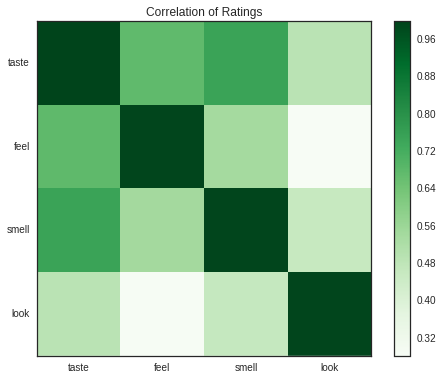

In [14]:
sns.set_style('white')

corr = beer_org[score_cols].corr()
corr_cols = ['taste', 'feel', 'smell', 'look']

plt.figure(figsize=(8, 6), dpi=80)
plt.imshow(corr, cmap = 'Greens', interpolation = 'none')    # Visualize the values in the entire data frame.
plt.colorbar()
plt.xticks(range(len(corr)), corr_cols)
plt.yticks(range(len(corr)), corr_cols);
plt.title("Correlation of Ratings")

This explains the reason why our result of appearance was so different than others. All the other fields are very highly correlated. When a beer tastes good, it usually feel and smell good too! Let's balance the data sets based on the smallest topic, which was taste (14190).

In [15]:
mask_idx = []
min_group_len = min(beer_group)

for g in beer_group.index:
    num = beer_group[g]
    mask_idx.extend(beer[beer.topic == g].index[:min_group_len].tolist())
    
beer = beer[beer.index.isin(mask_idx)]
beer.reset_index(inplace=True, drop=True)

In [16]:
beer.groupby('topic').size()

topic
appearance    14190
aroma         14190
palate        14190
taste         14190
dtype: int64

In [17]:
beer_balanced = beer

Since tastes, feel and smell are highly correlated, only use the most significant one of out these, which is taste. This will **remove multicollinearity** issue and turn this into a **binary classification problem**.

In [18]:
beer['is_appearance'] = beer.topic == 'appearance'

topic_cat = pd.Categorical(beer.topic)
beer['topic_id'] = topic_cat.codes
print topic_cat.categories

Index([u'appearance', u'aroma', u'palate', u'taste'], dtype='object')


In [19]:
beer = beer[beer.topic_id.isin([0, 3])]
beer.reset_index(inplace=True, drop=True)

In [20]:
beer.groupby('topic').size()

topic
appearance    14190
taste         14190
dtype: int64

Looks good. The data sets are completely balanced. Now let's take all the columns other than rating fields and reviews.

In [21]:
def concat_dummies(cols):
    dfs = []
    for col in cols:
        prefix = col.replace('_', '')
        dfs.append(pd.get_dummies(beer[col], prefix=prefix).iloc[:, 1:])
    return pd.concat(dfs, axis=1)

dummy_cols = ['brewer_country_name', 'brewer_type', 'style_name',
              'glass_type', 'user_name', 'us_state', 'favorite_style']
beer_d = concat_dummies(dummy_cols)

In [22]:
num_cols = ['num_ratings', 'weighted_avg', 'alcohol_by_volume', 'est_calories', 'is_seasonal']

for col in num_cols:
    beer_d[col] = beer[col]

Convert review into sparse matrix. 

In [24]:
unwanted_words = ['beer', 'updated']

def tokenize_and_stem(text):
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]

    # select only alphabets from tokens
    filtered_tokens = []
    for token in tokens:
        if re.match('^[a-z][a-z-\']+[a-z]$', token):
            if len(token) >= 2 and token not in unwanted_words:
                filtered_tokens.append(token)
            
    return [stemmer.stem(t) for t in filtered_tokens]

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(max_df=0.9,
                             min_df=0.01, 
                             stop_words='english',
                             strip_accents='ascii',
                             use_idf=True, 
                             tokenizer=tokenize_and_stem, 
                             ngram_range=(1,2))

tfidf_matrix = tfidf_vect.fit_transform(beer.review)

x_back = tfidf_matrix.toarray()
x_back_cols = tfidf_vect.get_feature_names()
tfidf_df = pd.DataFrame(x_back, columns=x_back_cols)
print tfidf_df.shape
tfidf_df.head()

(28380, 528)


,abv,acid,actual,add,aftertast,age,alcohol,ale,amaz,amber,...,wood,woodi,work,worth,wow,year,yeast,yeasti,yellow,yellow color
0,0,0,0,0,0,0,0,0.000000,0,0.000000,...,0,0,0,0,0,0.000000,0,0,0,0
1,0,0,0,0,0,0,0,0.101853,0,0.087066,...,0,0,0,0,0,0.142148,0,0,0,0
2,0,0,0,0,0,0,0,0.000000,0,0.000000,...,0,0,0,0,0,0.000000,0,0,0,0
3,0,0,0,0,0,0,0,0.000000,0,0.000000,...,0,0,0,0,0,0.000000,0,0,0,0
4,0,0,0,0,0,0,0,0.000000,0,0.000000,...,0,0,0,0,0,0.000000,0,0,0,0


In [9]:
# beer_d.reset_index(inplace=True, drop=True)
# tfidf_df.reset_index(inplace=True, drop=True)

In [26]:
target_col = 'is_appearance'
feat_cols = beer_d.columns.tolist()

X = pd.merge(beer_d, tfidf_df, how='outer', left_index=True, right_index=True)
y = beer[target_col]

X.shape

(28380, 5149)

We have 28,380 samples and 5149 features. Ready to train our Random Forest model!

In [3]:
# X.to_pickle('X.pickle')
# y.to_pickle('y.pickle')

X = pd.read_pickle('X.pickle')
y = pd.read_pickle('y.pickle')

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV

In [7]:
rfc = RandomForestClassifier(random_state=1)

tuned_parameters = [{'max_features': ['log2'], 
                     'n_estimators': [1000, 10000]}]

clf = GridSearchCV(rfc, tuned_parameters, scoring='accuracy', cv=2, n_jobs=1, verbose=2)
clf.fit(X.values, y.values)

Fitting 2 folds for each of 2 candidates, totalling 4 fits
[CV] max_features=log2, n_estimators=1000 ............................
[CV] ................... max_features=log2, n_estimators=1000 - 4.1min
[CV] max_features=log2, n_estimators=1000 ............................
[CV] ................... max_features=log2, n_estimators=1000 - 4.1min
[CV] max_features=log2, n_estimators=10000 ...........................
[CV] .................. max_features=log2, n_estimators=10000 -37.4min
[CV] max_features=log2, n_estimators=10000 ...........................
[CV] .................. max_features=log2, n_estimators=10000 -42.0min

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:  4.2min
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 89.0min finished


GridSearchCV(cv=2, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid=[{'max_features': ['log2'], 'n_estimators': [1000, 10000]}],
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring='accuracy', verbose=2)

In [8]:
clf.grid_scores_

[mean: 0.70962, std: 0.00088, params: {'max_features': 'log2', 'n_estimators': 1000},
 mean: 0.71399, std: 0.00011, params: {'max_features': 'log2', 'n_estimators': 10000}]

In [9]:
clf.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10000, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

[[2617  933]
 [ 984 2561]]

Accuracy 0.729809725159
Precision 0.732970807098



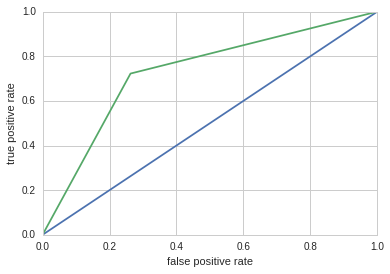

In [5]:
from sklearn.cross_validation import train_test_split
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.25)

rfc = clf.best_estimator_
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

cm = metrics.confusion_matrix(y_test, y_pred)
print cm
print

print 'Accuracy', metrics.accuracy_score(y_test, y_pred)
print 'Precision', metrics.precision_score(y_test, y_pred)
print 

roc = metrics.roc_curve(y_test, y_pred)
plt.figure()

# dummy, what's the worst random job we can do?
plt.plot([0, 0.5, 1], [0, 0.5, 1])

plt.plot(roc[0], roc[1])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')

In [6]:
feat_imp = pd.DataFrame({'feature':X.columns, 
                         'importance':rfc.feature_importances_,
                         'std': np.std([t.feature_importances_ for t in rfc.estimators_], axis=0)
                        })
feat_imp.sort('importance', ascending=False, inplace=True)

In [7]:
feat_imp[:10]

,feature,importance,std
4617,weighted_avg,0.012935,0.002776
4616,num_ratings,0.011940,0.002097
4618,alcohol_by_volume,0.010879,0.001805
4619,est_calories,0.010828,0.001821
4840,head,0.010683,0.004363
4639,aroma,0.008002,0.001527
4800,flavor,0.007665,0.001424
4988,pour,0.007561,0.001597
5091,tast,0.007470,0.001502
5117,veri,0.006505,0.001454


In [5]:
from sklearn.tree import export_graphviz

X_labels = [l.encode('ascii', 'ignore') for l in X.columns]

with open('topic_prediction_rfc.dot', 'wb') as f:
    f = export_graphviz(rfc.estimators_[0], out_file=f, feature_names=X_labels)

<img src="image/topic_prediction_rfc_1t_zoom.png">

#Step 7:  Extract Topic Key Words
Now that we proved review texts can be used to identify topics. Let's extract key words for each.

In [4]:
look = beer_balanced[beer_balanced.topic == 'appearance']['review'].reset_index(drop=True)
feel = beer_balanced[beer_balanced.topic == 'palate']['review'].reset_index(drop=True)
smell = beer_balanced[beer_balanced.topic == 'aroma']['review'].reset_index(drop=True)
taste = beer_balanced[beer_balanced.topic == 'taste']['review'].reset_index(drop=True)

In [10]:
import re
import nltk
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

unwanted_words = ['beer', 'updated']

def tokenize_and_stem(text):
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]

    # select only alphabets from tokens
    filtered_tokens = []
    for token in tokens:
        if re.match('^[a-z][a-z-\']+[a-z]$', token):
            if len(token) >= 2 and token not in unwanted_words:
                filtered_tokens.append(token)
            
    return [stemmer.stem(t) for t in filtered_tokens]

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

def vectorize(reviews):
    tfidf_vect = TfidfVectorizer(max_df=0.9,
                                 min_df=0.01, 
                                 stop_words='english',
                                 strip_accents='ascii',
                                 use_idf=True, 
                                 tokenizer=tokenize_and_stem, 
                                 ngram_range=(1,1),
                                 decode_error='ignore')

    tfidf_matrix = tfidf_vect.fit_transform(reviews)

    x_back = tfidf_matrix.toarray()
    x_back_cols = tfidf_vect.get_feature_names()
    return pd.DataFrame(x_back, columns=x_back_cols)

In [12]:
look_tfidf = vectorize(look)
feel_tfidf = vectorize(feel)
smell_tfidf = vectorize(smell)
taste_tfidf = vectorize(taste)

In [13]:
tfidfs = [look_tfidf.sum(), feel_tfidf.sum(), smell_tfidf.sum(), taste_tfidf.sum()]
tf = pd.concat(tfidfs, axis=1)
tf.columns = ['look', 'feel', 'smell', 'taste']
tf.fillna(0, inplace=True)
tf['max_col'] = tf.apply(lambda row: row.idxmax(), axis=1)

Frequent words for look topic.

In [14]:
look_tfidf.sum().order(ascending=False)[:20]

flavor    790.999044
light     790.716700
head      783.187095
aroma     774.234641
malt      766.275567
sweet     755.314652
tast      703.782937
hop       694.720482
pour      693.484160
veri      683.066158
bitter    593.265180
nice      584.035487
bottl     581.899112
finish    563.412968
dark      559.481745
bodi      539.841718
good      532.761425
color     502.866227
like      499.692154
white     493.304828
dtype: float64

Frequent words for taste topic.

In [15]:
taste_tfidf.sum().order(ascending=False)[:20]

flavor     800.687259
veri       791.347493
tast       762.329436
head       731.234244
aroma      730.433312
light      720.782630
hop        716.370735
sweet      692.907731
nice       661.631480
malt       655.921646
pour       649.138698
good       614.611407
finish     553.095635
bitter     549.114682
bottl      529.015207
like       524.487195
color      483.868732
dark       475.442081
white      431.165855
caramel    426.972556
dtype: float64

We have a problem here, flavor appears on the top for both of them. To solve this issue, let's do some **part-of-speech clean up**. 

## Part-of-Speech Clean Up
Only select these below tags to remove noise. Complete POS tag lisk can be found here. [Univ of Penn POS Tag List](http://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html)

Tag | Description | Example
----|-------------|-----------
NN  | Noun, singular or mass| sweet 
JJ  | Adjective   | good
JJR | Adjective, comparative| better
RB  | Adverb      | long
PRP$| Possessive pronoun | sour
NNS | Noun, plural | banana



In [16]:
from nltk import pos_tag

def pos_tag_filter(w):
    if pos_tag([w])[0][1] in ["NN", "JJ", "JJR", 'PRP$', 'NNS']:
        return True
    else:
        return False

for word in tf.index: 
    tf.loc[word, 'pos_filter'] = pos_tag_filter(word)

In [17]:
# filter by pos and only select necessary columns
tf = tf[tf.pos_filter == True][['look', 'feel', 'smell', 'taste', 'max_col']]

##Select Dominant Words
Now let's remove duplicate based on the total tf-idf scores. For the previous flavor case, we will say is is an important word for taste, as it got higher score.

In [21]:
#Key words for look
tf[tf.max_col=='look']['look'].order(ascending=False)[:20]

head       783.187095
malt       766.275567
sweet      755.314652
pour       693.484160
bottl      581.899112
dark       559.481745
bodi       539.841718
color      502.866227
chocol     467.462480
brown      465.064070
medium     461.714980
caramel    438.430663
slight     433.899990
coffe      393.681720
roast      380.582893
lace       376.916213
malti      366.513252
dri        348.169286
amber      344.236714
black      334.212043
Name: look, dtype: float64

In [22]:
#Key words for feel
tf[tf.max_col=='feel']['feel'].order(ascending=False)[:20]

light        832.947515
hop          732.017182
finish       570.970481
smooth       396.933870
carbon       348.283499
realli       321.546801
golden       299.530312
creami       287.018680
mild         280.252075
yellow       273.949981
small        271.347941
mouthfeel    268.562503
tap          267.794356
pale         261.331244
pretti       255.967852
fruiti       253.037258
hazi         244.270081
crisp        239.404518
yeast        231.946624
clean        203.217689
Name: feel, dtype: float64

In [23]:
#Key words for smell
tf[tf.max_col=='smell']['smell'].order(ascending=False)[:20]

aroma         867.741948
tast          778.756008
bitter        597.112294
littl         452.607806
bit           449.144179
smell         437.344070
nose          409.462745
citrus        392.528563
orang         363.023911
fruit         361.723525
alcohol       348.609669
sour          323.676258
strong        297.175556
lot           289.560911
vanilla       251.917403
big           241.058770
grapefruit    237.246264
pine          236.210473
quit          230.887866
spice         230.309891
Name: smell, dtype: float64

In [24]:
#Key words for taste
tf[tf.max_col=='taste']['taste'].order(ascending=False)[:20]

flavor     800.687259
veri       791.347493
nice       661.631480
good       614.611407
great      353.480593
drink      317.321937
hoppi      292.548509
balanc     291.690900
ale        267.650090
ipa        253.453547
better     222.776011
tart       217.925666
enjoy      206.590988
style      184.690530
complex    170.896505
refresh    169.812128
buddi      164.315413
tasti      163.491135
beer       162.661202
iphon      158.380149
Name: taste, dtype: float64

These look very good! For example, flavor, nice, hoppi, or balanc are all seem valid taste words! Whereas aroma, citrus, orang or vanilla seem to be more like small words.

#Step 8: Create Word Clouds for Topic Key Words

In [25]:
from wordcloud import WordCloud

wc = WordCloud(font_path='/Users/Ikkei/Library/Fonts/CabinSketch-Bold.ttf',
               width=2500,
               height=1800)


def create_word_cloud(vocab_str, col):
    wc.generate(vocab_str)

    plt.imshow(wc)
    plt.axis('off')
    plt.savefig(col + '_wordcloud.png', dpi=300)
    plt.show()

In [27]:
for col in ['look', 'feel', 'smell', 'taste']:
    vocab = tf[tf.max_col==col][col]
    vocab_str = ''
    
    for w in vocab.index:
        w_str = ' '.join([w] * int(vocab[w]))
        vocab_str += w_str
    
    create_word_cloud(vocab_str, col)

#Look
<img src="image/wordcloud/look_wordcloud.png">

#Feel
<img src="image/wordcloud/feel_wordcloud.png">

#Smell
<img src="image/wordcloud/smell_wordcloud.png">

#Taste
<img src="image/wordcloud/taste_wordcloud.png">

#Appendix 
Things tried but didn't include in this notebook

    1. SVM classification for lager/non-lager analysis. With Random Forest, we can see feature importance to it is more informative.

    2. Rating prediction based on reviews. It was very challenging. 

As Ed said, projects never end! I wanted to create a recommender engine as a web app and display images on a result page. That was why I created a web scraper. So that is going to be my next project!